<font size="5">**1. Import libraries**</font>


In [1]:
import os
import glob
import matplotlib.pyplot as plt
import urllib.request
import xarray as xr
import calendar
import zipfile
import requests
import io
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import statsmodels.api as sm

<font size="5">**2. Download maximum temperature data for the entire US**</font>


In [3]:
url_base = "https://www.northwestknowledge.net/metdata/data/"

# download the max temperature if the data has not already been downloaded
url_min = url_base + f"tmmx_2020.nc"
savename = f'tmax_gridmet_2020.nc'
if os.path.exists(f"./{savename}") is not True:
    urllib.request.urlretrieve(url_min, savename)
tmax_2020_US = xr.open_dataset(savename)

Now we take a look at the data and adjust its variable name from 'air_temperature' to 'temp' for simplicity.

In [5]:
tmax_2020_US

<xarray.Dataset> Size: 2GB
Dimensions:          (lon: 1386, lat: 585, day: 366, crs: 1)
Coordinates:
  * lon              (lon) float64 11kB -124.8 -124.7 -124.7 ... -67.1 -67.06
  * lat              (lat) float64 5kB 49.4 49.36 49.32 ... 25.15 25.11 25.07
  * day              (day) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
  * crs              (crs) uint16 2B 3
Data variables:
    air_temperature  (day, lat, lon) float64 2GB ...
Attributes: (12/22)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    last_permanent_slice:       306
    last_early_slice:           366
    last_provisional_slice:     360
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [6]:
tmax_2020_US = tmax_2020_US.rename({'air_temperature':'temp'})
tmax_2020_US

<xarray.Dataset> Size: 2GB
Dimensions:  (lon: 1386, lat: 585, day: 366, crs: 1)
Coordinates:
  * lon      (lon) float64 11kB -124.8 -124.7 -124.7 ... -67.14 -67.1 -67.06
  * lat      (lat) float64 5kB 49.4 49.36 49.32 49.28 ... 25.15 25.11 25.07
  * day      (day) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
  * crs      (crs) uint16 2B 3
Data variables:
    temp     (day, lat, lon) float64 2GB ...
Attributes: (12/22)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    last_permanent_slice:       306
    last_early_slice:           366
    last_provisional_slice:     360
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

<font size="5">**3. Visualize the data for entire US**</font>

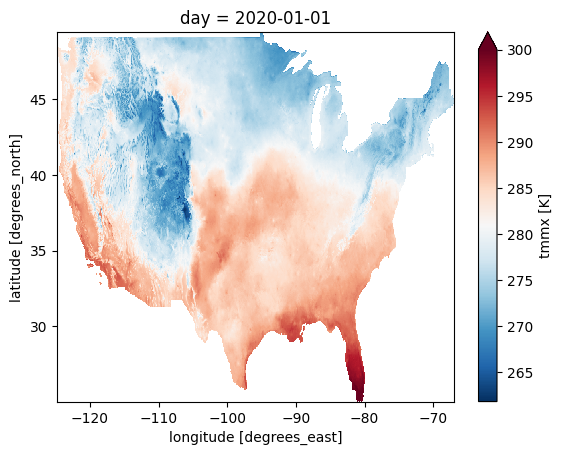

In [14]:
tmax_2020_US.temp[0,:,:].plot(cmap='RdBu_r', vmax=300)

The temperature data is initially provided in Kelvin. I will convert this data to Fahrenheit. Subsequently, I will compute the monthly average of the maximum temperatures and generate a plot for the month of January in 2020.

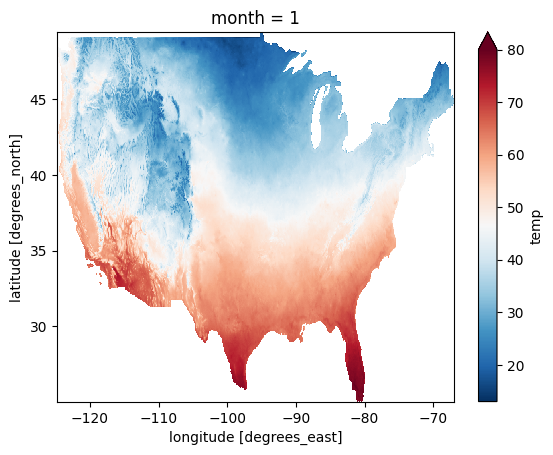

In [29]:
tmax_2020_US_mon = tmax_2020_US.groupby('day.month').mean() ## generate monthly data of maximum temperature
tmax_2020_US_adj_mon = (tmax_2020_US_mon-273.15)*1.8 + 32 # Convert Kelvin to Fahrenheit
tmax_2020_US_adj_mon.temp[0,:,:].plot(cmap='RdBu_r', vmax=80)

Next, the monthly maximum temperature is plotted for all 12 months of 2020 as follows:

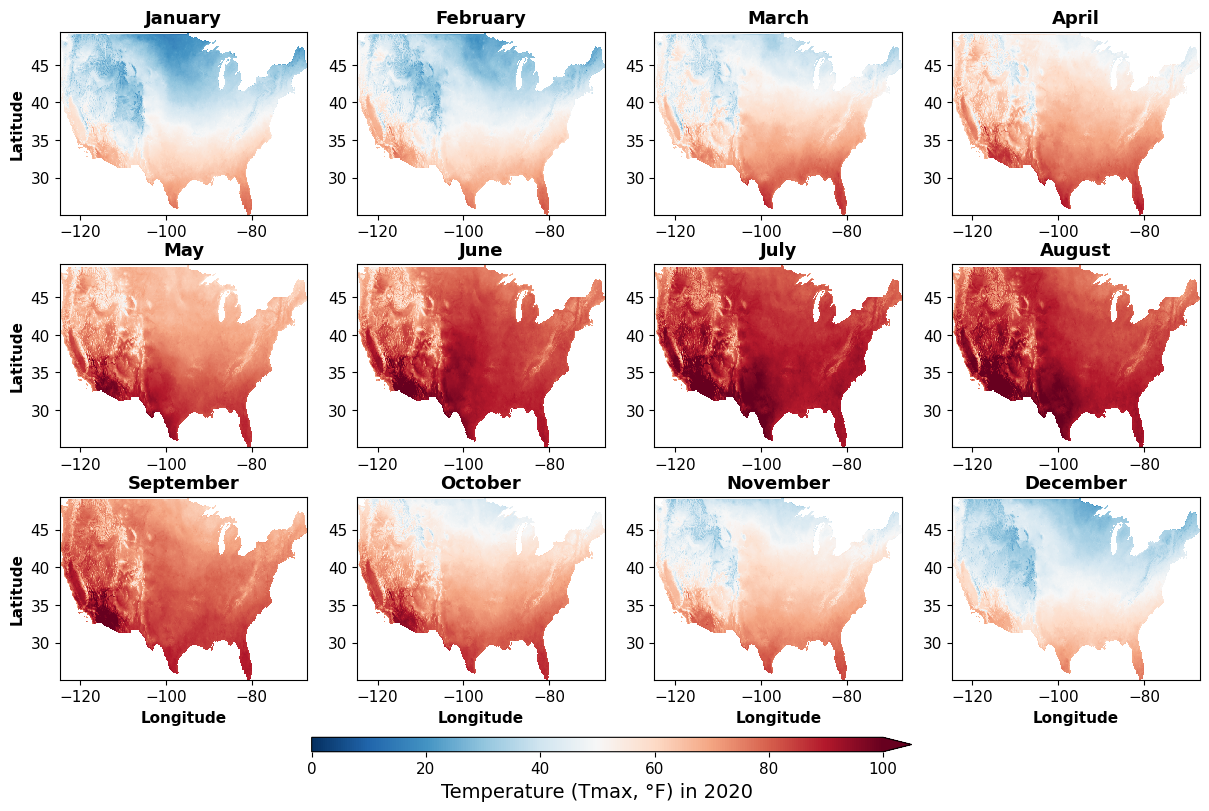

In [57]:
fig = plt.figure(figsize=[12,8], facecolor='w')
plt.subplots_adjust(bottom=0.15, top=0.96, left=0.04, right=0.99, 
                    wspace=0.2, hspace=0.27) # wspace and hspace adjust the horizontal and vertical spaces, respectively.
nrows = 3
ncols = 4
for i in range(1, 13):
    plt.subplot(nrows, ncols, i)
    dataplot = tmax_2020_US_adj_mon.temp[i-1, :, :] 
    p = plt.pcolormesh(tmax_2020_US_adj_mon.lon, tmax_2020_US_adj_mon.lat, dataplot,
                   vmax = 100, vmin = 0, cmap = 'RdBu_r',
                   ) 
    #plt.xlim([233,295])
    #plt.ylim([25,50])
    plt.title(calendar.month_name[dataplot.month.values], fontsize = 13, 
              fontweight = 'bold', color = 'k')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
    if i % ncols == 1: # Add ylabel for the very left subplots
        plt.ylabel('Latitude', fontsize = 11, fontweight = 'bold')
    if i > ncols*(nrows-1): # Add xlabel for the bottom row subplots
        plt.xlabel('Longitude', fontsize = 11, fontweight = 'bold')

# Add a colorbar at the bottom:
cax = fig.add_axes([0.25, 0.06, 0.5, 0.018])
cb = plt.colorbar(cax=cax, orientation='horizontal', extend = 'max',)
cb.ax.tick_params(labelsize=11)
cb.set_label(label='Temperature (Tmax, °F) in 2020', color = 'k', size=14)

# Now we can save a high resolution (300dpi) version of the figure:
plt.savefig('Fig_tmax_2020.png', format = 'png', dpi = 300)

<font size="5">**4. Clip the dataset for California**</font>

In [43]:
# Step 1. download the shapefile for California boundary
url_states = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"
response_states = requests.get(url_states)
with zipfile.ZipFile(io.BytesIO(response_states.content)) as z:
    z.extractall("cb_2022_us_state_20m")

## Load the shapefile
shapefile_path = "cb_2022_us_state_20m/cb_2022_us_state_20m.shp"
gdf_states = gpd.read_file(shapefile_path)

## Filter the GeoDataFrame to include only California
gdf_California = gdf_states[gdf_states['NAME'] == 'California']

## Reproject the Shapefile to match the CRS of the temperature data
# CRS of temperature data is EPSG:4326
gdf_California = gdf_California.to_crs(epsg=4326)

# Step 2. Crop the temeprature dataset by California boundary
tmax_2020_US_adj_mon.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
tmax_2020_US_adj_mon.rio.write_crs("epsg:4326", inplace=True)
clipped_nc = tmax_2020_US_adj_mon.rio.clip(gdf_California.geometry.apply(mapping), gdf_California.crs, drop=True)
clipped_nc.to_netcdf(f"clipped_file.nc")

<font size="5">**5. Visualize the data over California**</font>

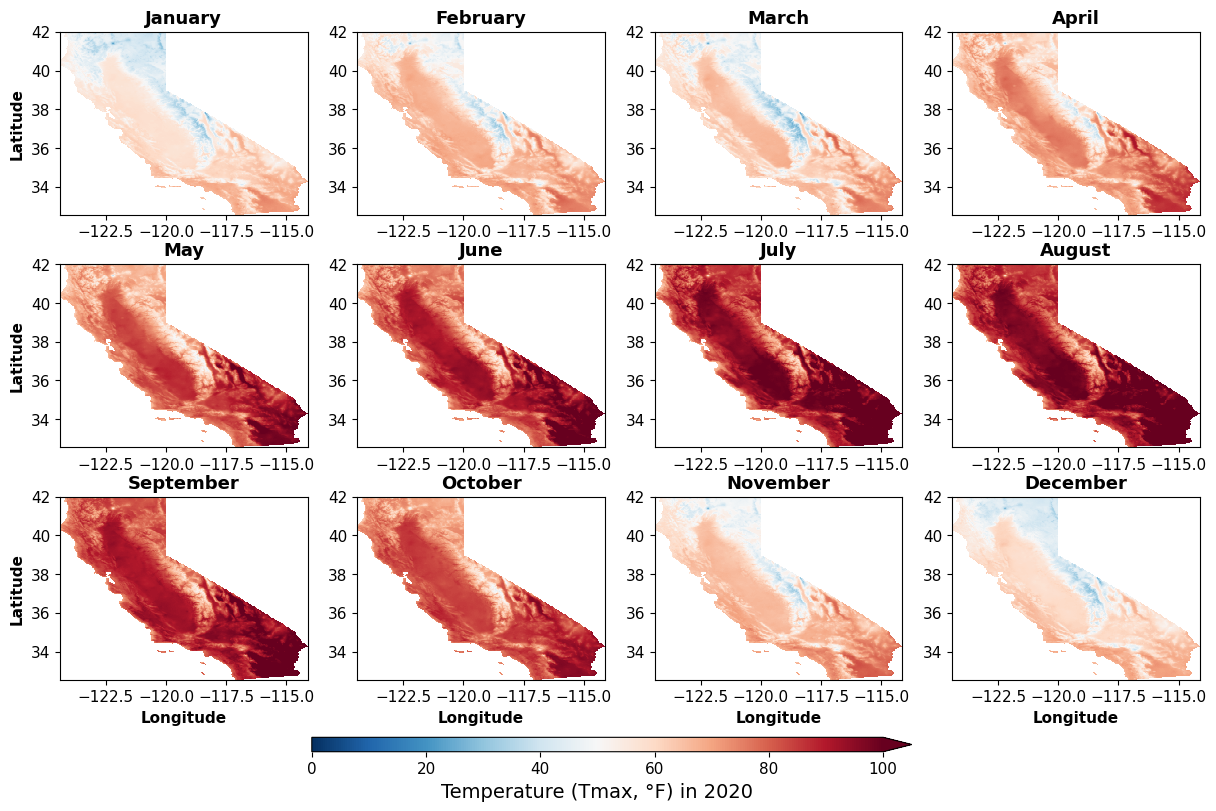

In [59]:
fig = plt.figure(figsize=[12,8], facecolor='w')
plt.subplots_adjust(bottom=0.15, top=0.96, left=0.04, right=0.99, 
                    wspace=0.2, hspace=0.27) # wspace and hspace adjust the horizontal and vertical spaces, respectively.
nrows = 3
ncols = 4
for i in range(1, 13):
    plt.subplot(nrows, ncols, i)
    dataplot = clipped_nc.temp[i-1, :, :] 
    p = plt.pcolormesh(clipped_nc.lon, clipped_nc.lat, dataplot,
                   vmax = 100, vmin = 0, cmap = 'RdBu_r',
                   ) 
    plt.title(calendar.month_name[dataplot.month.values], fontsize = 13, 
              fontweight = 'bold', color = 'k')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
    if i % ncols == 1: # Add ylabel for the very left subplots
        plt.ylabel('Latitude', fontsize = 11, fontweight = 'bold')
    if i > ncols*(nrows-1): # Add xlabel for the bottom row subplots
        plt.xlabel('Longitude', fontsize = 11, fontweight = 'bold')

# Add a colorbar at the bottom:
cax = fig.add_axes([0.25, 0.06, 0.5, 0.018])
cb = plt.colorbar(cax=cax, orientation='horizontal', extend = 'max',)
cb.ax.tick_params(labelsize=11)
cb.set_label(label='Temperature (Tmax, °F) in 2020', color = 'k', size=14)
